## Plot the generated daily soil and runoff cation concentrations

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams
from matplotlib.patches import Patch

site = 'HBR'
prefix = '20250210'
suffix = '3year_rmethod1' # _VertOMappCtrl

rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 16

elm_thickness = np.diff(np.array([0, 1.75, 4.51, 9.06, 16.55, 28.91, 49.29, 82.89, 138.28]))

In [2]:
flist = [os.path.join(os.environ['E3SM_ROOT'], 'output', 
                        f'{prefix}_HBR_ICB20TRCNPRDCTCBC_{suffix}erw', 'run', 
                        f'{prefix}_HBR_ICB20TRCNPRDCTCBC_{suffix}erw.elm.h1.{yy}-01-01-00000.nc') \
            for yy in range(1980, 2022)]

# reference run
"""flist_ctrl = [os.path.join(os.environ['E3SM_ROOT'], 'output', 
                        f'{prefix}_HBR_ICB20TRCNPRDCTCBC_{suffix}appCtrlerw', 'run', 
                        f'{prefix}_HBR_ICB20TRCNPRDCTCBC_{suffix}appCtrlerw.elm.h1.{yy}-01-01-00000.nc') \
            for yy in range(1980, 2022)]"""

hr = xr.open_mfdataset(flist)
#hr_ctrl = xr.open_mfdataset(flist_ctrl)
tvec = pd.DatetimeIndex([pd.Timestamp(year=t.year, month=t.month, day=t.day) \
                         for t in hr['time'].to_index()])

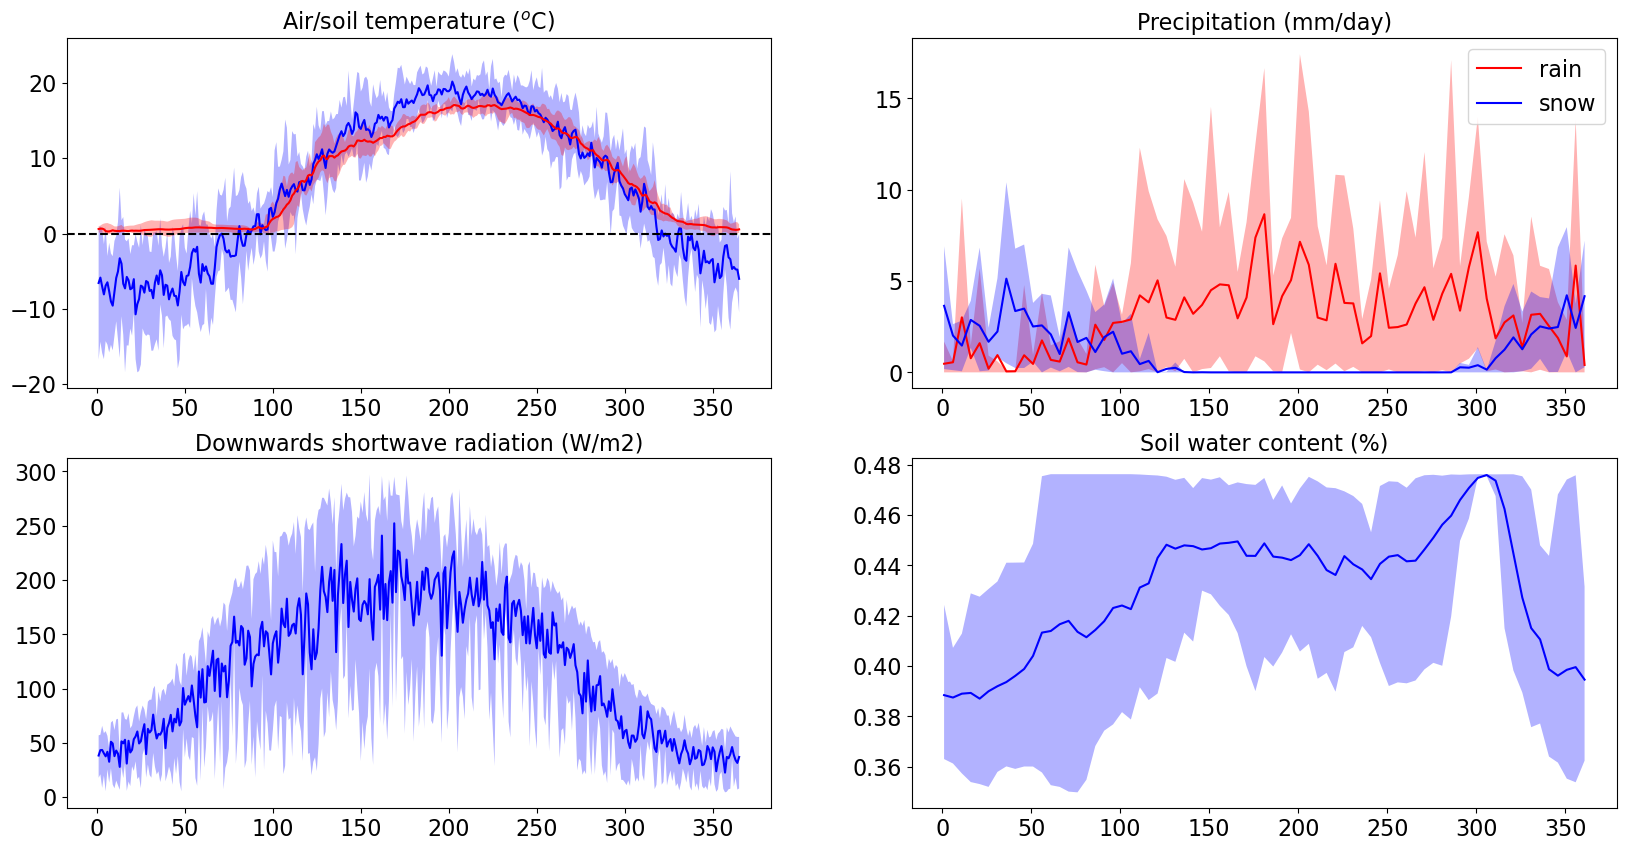

In [ ]:
# Meteorological variables

met_sim = pd.DataFrame({
    'rain': hr['RAIN'][:, 0] * 86400,
    'snow': hr['SNOW'][:, 0] * 86400, 
    'tair': hr['TBOT'][:, 0] - 273.15,
    'et': (hr['QVEGE'] + hr['QVEGT'] + hr['QSOIL'])[:, 0]*86400,
    'runoff': (hr['QRUNOFF'][:, 0] + hr['QDRAI'][:, 0]) * 86400,
    'tsoil': (np.matmul(hr['TSOI'][:, :6, 0].values,
                        hr['levgrnd'][:6].values.reshape(-1,1)) / \
              np.sum(hr['levgrnd'][:6].values) - 273.15)[:,0], # average TSOIL of 30cm
    'theta': (np.matmul(hr['H2OSOI'][:, :6, 0].values,
                        hr['levgrnd'][:6].values.reshape(-1,1)) / \
              np.sum(hr['levgrnd'][:6].values))[:,0], # average soil water content of 30cm
    'srad': hr['FSDS'][:, 0]
}, index = tvec[:])

# daily annual cycle
fig, axes = plt.subplots(2, 2, figsize = (20,10))

ax = axes.flat[0]
metbox = met_sim['tair'].values.reshape(-1, 365)
ax.plot(range(1, 366), metbox.mean(axis = 0), '-b', label = 'Tair')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
metbox = met_sim['tsoil'].values.reshape(-1, 365)
ax.plot(range(1, 366), metbox.mean(axis = 0), '-r', label = 'Tsoil')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
ax.axhline(0, ls = '--', color = 'k')
ax.set_title('Air/soil temperature ($^o$C)')

# resample to 5-day sums to smooth things out
ax = axes.flat[1]
clist = ['r','b']
for i, var in enumerate(['rain', 'snow']):
    metbox = met_sim[var].values.reshape(-1, 73, 5).mean(axis = 2) # pentad average
    ax.plot(range(1, 366, 5), metbox.mean(axis = 0), '-', color = clist[i], label = var)
    ax.fill_between(
        range(1, 366, 5),
        np.nanpercentile(metbox, 10, axis = 0),
        np.nanpercentile(metbox, 90, axis = 0), 
        fc = clist[i], alpha = 0.3
    )
ax.set_title('Precipitation (mm/day)')
ax.legend()
#ax.set_yscale('log')

ax = axes.flat[2]
metbox = met_sim['srad'].values.reshape(-1, 365)
ax.plot(range(1, 366), metbox.mean(axis = 0), '-b')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
ax.set_title('Downwards shortwave radiation (W/m2)')

ax = axes.flat[3]
metbox = met_sim['theta'].values.reshape(-1, 73, 5).mean(axis = 2) # pantad averages
ax.plot(range(1, 366, 5), metbox.mean(axis = 0), '-b')
ax.fill_between(
    range(1, 366, 5),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
ax.set_title('Soil water content (%)')
plt.savefig('./temp/hbr_met.png', dpi = 600., bbox_inches = 'tight')

In [ ]:
# Collect all the data-model variables

# (1) SWE
swe_obs = read_snowcourse().sort_index()
swe_obs.loc[swe_obs < 0] = np.nan
swe_obs = swe_obs.drop(swe_obs.index[1271]) # remove duplicate index; SWE = 0 anyway
swe_sim = pd.Series(hr['H2OSNO'][:, 0], index = tvec[:])

overlap = pd.date_range('2012-01-01', '2021-12-31', freq = '1D')
swe_obs = swe_obs.reindex(overlap).interpolate(method = 'linear', limit = 20)
swe_sim = swe_sim.reindex(overlap)

# drop Feb 29
swe_obs = swe_obs.loc[~((swe_obs.index.month == 2) & (swe_obs.index.day == 29))]
swe_sim = swe_sim.loc[~((swe_sim.index.month == 2) & (swe_sim.index.day == 29))]


# (2) annual maximum LAI
lai_obs = read_lai()
lai_obs_mean = lai_obs.groupby('Year').mean()
lai_obs_std = lai_obs.groupby('Year').std()

lai_sim = pd.Series(hr['TLAI'][:, 0], index = tvec[:])
lai_sim_mean = lai_sim.resample('1Y').max()


# (3) Runoff
runoff_obs = read_runoff() # mm/day
runoff_sim = pd.Series(
    (hr['QRUNOFF'][:, 0] + hr['QDRAI'][:, 0]) * 86400, 
    index = tvec[:]
)

et_sim = pd.Series(
   (hr['QVEGE'] + hr['QVEGT'] + hr['QSOIL'])[:, 0]*86400,
    index = tvec[:]
)

common_index = runoff_obs.index.intersection(runoff_sim.index)
runoff_obs = runoff_obs.loc[common_index]
runoff_sim = runoff_sim.loc[common_index]
et_sim = et_sim.loc[common_index]

/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = data.loc['STA2', 'swe']


/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


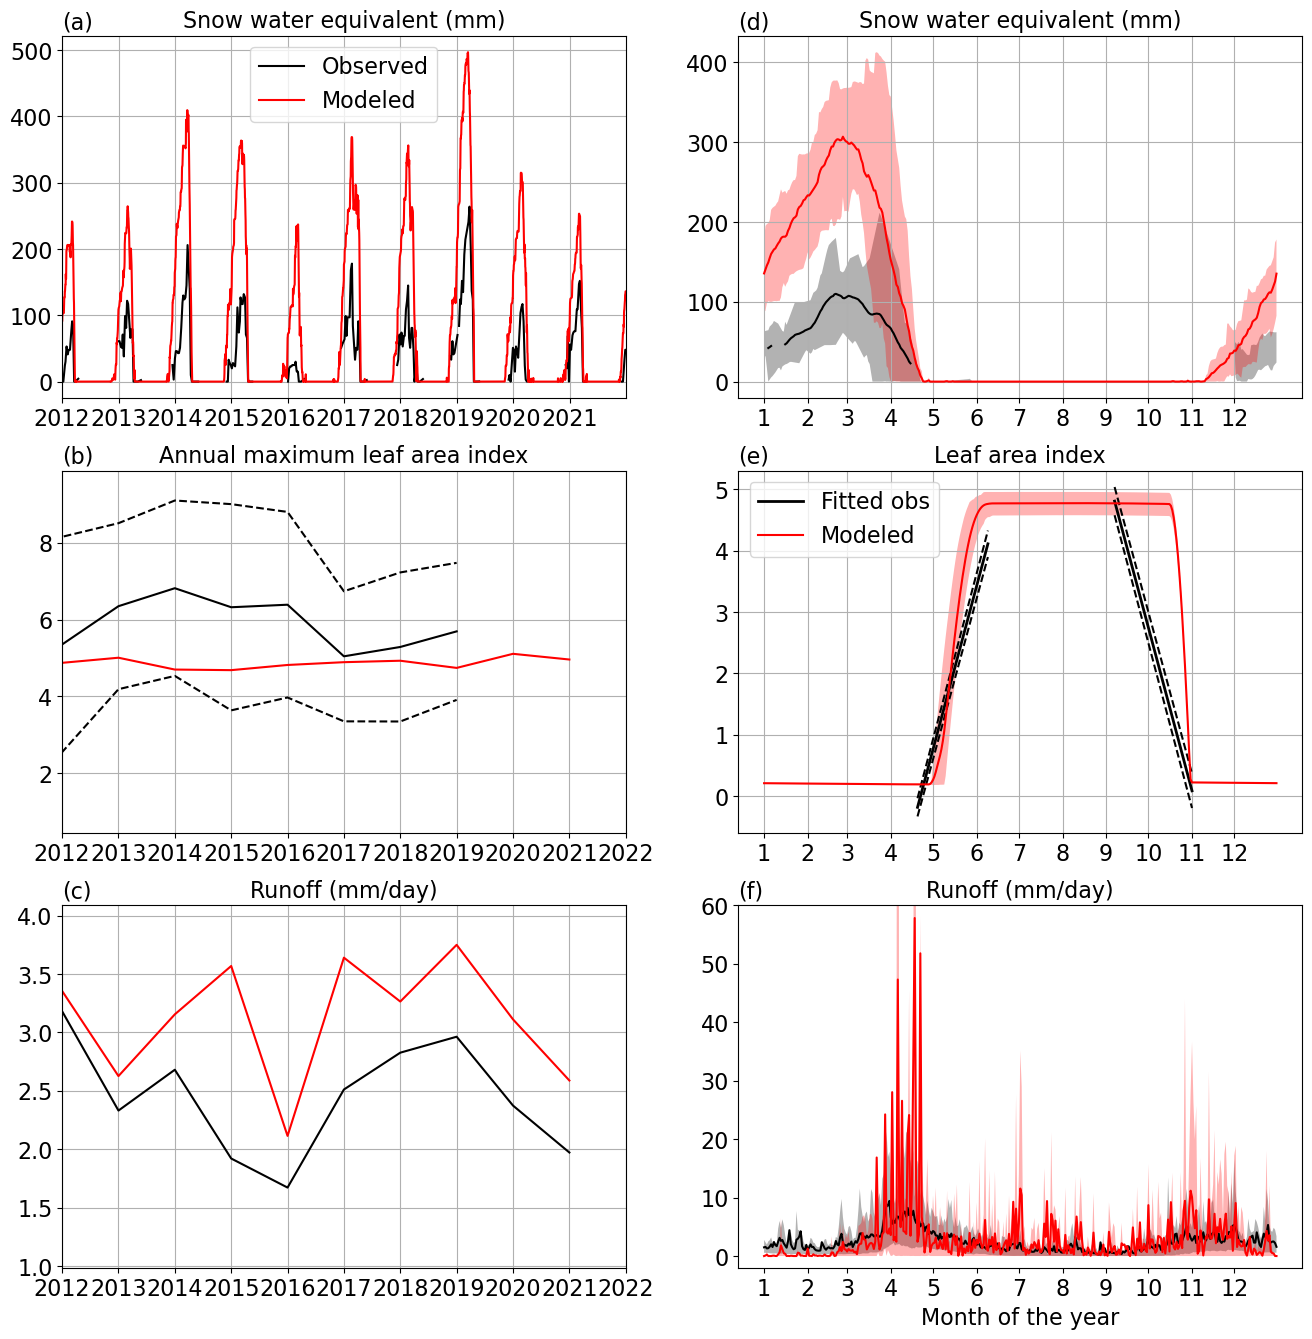

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (16,16))

#########################
# Time series plots
#########################

# (1) snow water equivalent
ax = axes[0, 0]
ax.plot(swe_obs.index, swe_obs, '-k', label = 'Observed')
ax.plot(swe_sim.index, swe_sim, '-r', label = 'Modeled')
ax.legend()
ax.set_xticks(pd.date_range('2012-01-01', '2022-01-01', freq = '1YS'))
ax.set_xticklabels(range(2012, 2023))
ax.set_xlim([pd.Timestamp('2012-01-01'), pd.Timestamp('2021-12-31')])
ax.grid(True)
ax.set_title('Snow water equivalent (mm)')
ax.text(0., 1.02, '(a)', transform = ax.transAxes)

# (2) annual maximum leaf area index
ax = axes[1,0]
ax.plot(lai_obs_mean.index, lai_obs_mean, '-k', label = 'Observed')
ax.plot(lai_obs_std.index, lai_obs_mean - 2*lai_obs_std, '--k')
ax.plot(lai_obs_std.index, lai_obs_mean + 2*lai_obs_std, '--k')
ax.plot(lai_sim_mean.index.year, lai_sim_mean, '-r', label = 'Modeled')
#ax.legend()
ax.set_xlim([2012, 2022])
ax.set_xticks(range(2012, 2023))
ax.grid(True)
ax.set_title('Annual maximum leaf area index')
ax.text(0., 1.02, '(b)', transform = ax.transAxes)

# (3) annual average runoff
ax = axes[2,0]
obs_ann = runoff_obs.resample('1Y').mean()
sim_ann = runoff_sim.resample('1Y').mean()
ax.plot(obs_ann.index.year, obs_ann, '-k', label = 'Observed')
ax.plot(sim_ann.index.year, sim_ann, '-r', label = 'Modeled')
ax.set_xlabel('')
#ax.legend()
ax.set_title('Runoff (mm/day)')
ax.set_xlim([2012, 2022])
ax.set_xticks(range(2012, 2023))
ax.grid(True)
ax.text(0., 1.02, '(c)', transform = ax.transAxes)

#plt.savefig(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'plot_ERWsites',
#                         'hbr_timeseries.png'), dpi = 600., bbox_inches = 'tight')

#########################
# Seasonal cycle plots
#########################
#fig, axes = plt.subplots(3, 2, figsize = (16,12), sharex = True)
#fig.subplots_adjust(hspace = 0.1)
dayofyear = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])

# (1) SWE
# seasonal cycle
# The simulated values are more similar to the North-facing slope in 
# 
# Penn, C. A., Wemple, B. C., & Campbell, J. L. (2012). Forest influences on snow accumulation and snowmelt at the Hubbard Brook Experimental Forest, New Hampshire, USA. Hydrological Processes, 26(17), 2524–2534. https://doi.org/10.1002/hyp.9450
# 
# winter snow packs melt more rapidly in forest openings on sun-exposed slopes
ax = axes[0,1]

swe_obs_cycle = swe_obs.values.reshape(-1, 365) # pantad averages
ax.plot(range(1, 366), swe_obs_cycle.mean(axis = 0), '-k')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(swe_obs_cycle, 10, axis = 0),
    np.nanpercentile(swe_obs_cycle, 90, axis = 0), 
    fc = 'k', alpha = 0.3
)

swe_sim_cycle = swe_sim.values.reshape(-1, 365) # pantad averages
ax.plot(range(1, 366), swe_sim_cycle.mean(axis = 0), '-r')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(swe_sim_cycle, 10, axis = 0),
    np.nanpercentile(swe_sim_cycle, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
ax.grid(True)
ax.set_title('Snow water equivalent (mm)')
ax.set_xticks(dayofyear)
ax.set_xticklabels(range(1, 13))
ax.text(0., 1.02, '(d)', transform = ax.transAxes)

# (2) Leaf area phenology
lai_sim = pd.Series(hr['TLAI'][:, 0], index = tvec[:])
spr, fal = read_pheno()
slope_spr, intercept_spr, slope_std_spr = spr
slope_fal, intercept_fal, slope_std_fal = fal

ax = axes[1,1]

data = lai_sim.values.reshape(-1, 365)
ax.plot([110, 160], [110*slope_spr + intercept_spr, 
                     160*slope_spr + intercept_spr], '-k', lw = 2, 
        label = 'Fitted obs')
ax.plot([110, 160], [110*(slope_spr + slope_std_spr) + intercept_spr, 
                     160*(slope_spr + slope_std_spr) + intercept_spr], '--k')
ax.plot([110, 160], [110*(slope_spr - slope_std_spr) + intercept_spr, 
                     160*(slope_spr - slope_std_spr) + intercept_spr], '--k')
ax.plot([250, 305], [250*slope_fal + intercept_fal, 
                     305*slope_fal + intercept_fal], '-k', lw = 2)
ax.plot([250, 305], [250*(slope_fal + slope_std_fal) + intercept_fal, 
                     305*(slope_fal + slope_std_fal) + intercept_fal], '--k')
ax.plot([250, 305], [250*(slope_fal - slope_std_fal) + intercept_fal, 
                     305*(slope_fal - slope_std_fal) + intercept_fal], '--k')
ax.plot(range(1, 366), data.mean(axis = 0), '-r', label = 'Modeled')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(data, 10, axis = 0),
    np.nanpercentile(data, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
ax.legend(loc = 'upper left')
ax.set_title('Leaf area index')
ax.grid(True)
ax.set_xticks(dayofyear)
ax.set_xticklabels(range(1, 13))
ax.text(0., 1.02, '(e)', transform = ax.transAxes)

# (3) streamflow seasonal cycle
ax = axes[2,1]
obs_box = runoff_obs.values.reshape(-1, 365)
ax.plot(range(1, 366), obs_box.mean(axis = 0), '-k', label = 'Observed')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(obs_box, 10, axis = 0),
    np.nanpercentile(obs_box, 90, axis = 0), 
    fc = 'k', alpha = 0.3
)

sim_box = runoff_sim.values.reshape(-1, 365)
ax.plot(range(1, 366), sim_box.mean(axis = 0), '-r', label = 'Modeled')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(sim_box, 10, axis = 0),
    np.nanpercentile(sim_box, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
#ax.set_yscale('log')
#ax.legend()
ax.set_title('Runoff (mm/day)')
ax.text(0., 1.02, '(f)', transform = ax.transAxes)

"""# (4) evapotranspiration seasonal cycle
ax = axes.flat[3]
sim_box = et_sim.values.reshape(-1, 365)
ax.plot(range(1, 366), sim_box.mean(axis = 0), '-r', label = 'Modeled')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(sim_box, 10, axis = 0),
    np.nanpercentile(sim_box, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
ax.set_title('Evapotranspiration (mm/day)')"""
ax.set_xticks(dayofyear)
ax.set_xticklabels(range(1, 13))
ax.set_xlabel('Month of the year')
ax.set_ylim([-2, 60])

plt.savefig(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'plot_ERWsites',
                         'hbr_ecology.png'), dpi = 600., bbox_inches = 'tight')

In [ ]:
# It not useful to compare streamflow concentration, because 
# 
# the model simulated result is runoff & drainage loss from top 30cm soil
# streamflow concentration is to a large extent controled by groundwater processes
# 
# moreover, the stream concentration is mainly affected by the wollastonite that 
# fell directly into the stream during application 
# Peters, S. C., Blum, J. D., Driscoll, C. T., & Likens, G. E. (2004). Dissolution of wollastonite during the experimental manipulation of Hubbard Brook Watershed 1. Biogeochemistry, 67(3), 309–329. https://doi.org/10.1023/B:BIOG.0000015787.44175.3f

"""
cation_export_obs = read_streamChem() * 1e-6 # umol/L -> mol/L


LEVGRND = np.array([0.007100635, 0.027925, 0.06225858, 0.1188651, 0.2121934,
                    0.3660658, 0.6197585, 1.038027, 1.727635, 2.864607, 4.739157,
                    7.829766, 12.92532, 21.32647, 35.17762])
LEVGRND_I = np.append(np.insert(
    (LEVGRND[1:] + LEVGRND[:-1])*0.5, 0, 0
), LEVGRND[-1] + 0.5 * (LEVGRND[-1] - LEVGRND[-2]))
THICKNESS = np.diff(LEVGRND_I)

top_layer_water = np.matmul(hr['H2OSOI'][:, :6, 0].values, (THICKNESS[:6].reshape(-1, 1)))
all_water = np.matmul(hr['H2OSOI'][:, :, 0].values, THICKNESS.reshape(-1,1))

cation_export_sim = pd.DataFrame(
    (hr['cation_leached'][:, :, 0] + hr['cation_runoff'][:, :, 0]) / \
    ((hr['QRUNOFF'] + hr['QDRAI'])[:,0].values.reshape(-1,1) * top_layer_water / all_water),
    index = tvec, columns = ['Ca2+','Mg2+','Na+','K+','Al3+'])

cation_export_obs = cation_export_obs.loc[
    (cation_export_obs.index.year >= 1996) & 
    (cation_export_obs.index.year <= 2010)]
cation_export_sim = cation_export_sim.loc[
    (cation_export_sim.index.year >= 1996) & 
    (cation_export_sim.index.year <= 2010), :]

cation_export_sim = cation_export_sim.loc[
    cation_export_obs.index.intersection(cation_export_sim.index), :]

fig, axes = plt.subplots(3, 2, figsize = (16, 12), sharex = True)
for i, (obs_ca, sim_ca, mass_ca) in enumerate(
    zip(['Ca2', 'Mg2', 'Na', 'K', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'],
        [40, 24, 23, 29, 27])
):
    ax = axes.flat[i]

    ax.plot(cation_export_obs.index, cation_export_obs[obs_ca], label = 'Observed')
    ax.plot(cation_export_sim.index, cation_export_sim[sim_ca] / mass_ca,
            label = 'Modeled')

    ax.set_xlabel('')
    ax.set_ylabel('mol L$^{-1}$')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'{sim_ca} export rate in streamflow')
plt.savefig('./temp/hbr_cation_export.png', dpi = 600., bbox_inches = 'tight')
"""

In [ ]:
# Layerwise soil pore water cation concentration
# Oe: 0-2.5cm (lacks std in 2020)
# Oa: 2.5-7cm
# B: 20-60cm
soil_pore_obs, soil_pore_obs_std = read_lysimeter()

# convert from g m-3 soil to mol/kg porewater
soil_pore_sim = {}
for i, (cation, mass_ca) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [40, 24, 23, 29, 27])):
    soil_pore_sim[(cation, 'Oe')] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,:2,0] / hr['H2OSOI'][:,:2,0] / mass_ca / 1000) *
          np.array([1.75, 2.5-1.75]).reshape(1,-1)).sum(axis = 1) / 2.5, 
        index = tvec)
    soil_pore_sim[(cation, 'Oa')] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,1:3,0] / hr['H2OSOI'][:,1:3,0] / mass_ca / 1000) *
          np.array([4.51-2.5, 7-4.51]).reshape(1,-1)).sum(axis = 1) / (7-2.5), 
        index = tvec)
    soil_pore_sim[(cation, 'B')] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,4:6,0] / hr['H2OSOI'][:,4:6,0] / mass_ca / 1000) *
          np.array([28.91-20, 49.29-28.91]).reshape(1,-1)).sum(axis = 1) / (49.29-20), #, 60-49.29, (60-20)
        index = tvec)
soil_pore_sim[('pH', 'Oe')] = pd.Series( 
        (hr[f'soil_pH'][:,:2,0] * np.array([1.75, 2.5-1.75]).reshape(1,-1)).sum(axis = 1) / 2.5, 
        index = tvec)
soil_pore_sim[('pH', 'Oa')] = pd.Series( 
    (hr[f'soil_pH'][:,1:3,0] * np.array([4.51-2.5, 7-4.51]).reshape(1,-1)).sum(axis = 1) / (7-2.5), 
        index = tvec)
soil_pore_sim[('pH', 'B')] = pd.Series( 
    (hr[f'soil_pH'][:,4:6,0] * np.array([28.91-20, 49.29-28.91]).reshape(1,-1) # , 60-49.29
     ).sum(axis = 1) / (49.29-20), # (60-20), 
        index = tvec)
soil_pore_sim = pd.DataFrame(soil_pore_sim).stack()
soil_pore_sim.index = soil_pore_sim.index.reorder_levels([1, 0])
soil_pore_sim = soil_pore_sim.sort_index()

# Show 3-layer integrated modeled outcome too!!!
for layer in ['Oe', 'Oa', 'B', 'OaeB']:
    if layer == 'OaeB':
        obs = (soil_pore_obs.loc['Oe', :] * 0.025 + soil_pore_obs.loc['Oa', :] * 0.045 + 
               soil_pore_obs.loc['B', :] * 0.3929) / (0.4 + 0.025 + 0.045)

        obs_std = ((soil_pore_obs_std.loc['Oe', :]**2 * 0.025 + 
                    soil_pore_obs_std.loc['Oa', :]**2 * 0.045 + 
                    soil_pore_obs_std.loc['B', :]**2 * 0.4) / (0.4 + 0.025 + 0.045))**0.5

        sim = (soil_pore_sim.loc['Oe', :] * 0.025 + soil_pore_sim.loc['Oa', :] * 0.045 + 
               soil_pore_sim.loc['B', :] * 0.3929) / (0.4 + 0.025 + 0.045)
    else:
        obs = soil_pore_obs.loc[layer, :]
        obs_std = soil_pore_obs_std.loc[layer, :]
        sim = soil_pore_sim.loc[layer, :]

    index = obs.index.intersection(obs_std.index).intersection(sim.index)
    obs = obs.loc[index, :]
    obs_std = obs_std.loc[index, :]
    sim = sim.loc[index, :]

    fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True)
    for i, (obs_ca, sim_ca, name) in enumerate(
        zip(['Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt', 'pH'],
            ['Ca2+','Mg2+','Na+','K+','Al3+', 'pH'], 
            ['Ca$^{2+}$', 'Mg$^{2+}$', 'Na$^{+}$', 'K$^{+}$', 'Al$^{3+}$', 'pH'])
    ):
        ax = axes.flat[i]
        ax.plot(index, obs[obs_ca], '-k', label = 'Obs')
        ax.fill_between(
            index, obs[obs_ca] - obs_std[obs_ca], obs[obs_ca] + obs_std[obs_ca], 
            fc = 'k', alpha = 0.3
        )
        ax.plot(index, sim[sim_ca], '-r', label = 'Sim')

        ax.set_xlabel('')
        if np.mod(i, 3) == 0:
            ax.set_ylabel('mol/kg')
        if sim_ca != 'pH':
            ax.set_yscale('log')
        ax.set_title(f'Soil pore {name} concentration')
        plt.setp(ax.get_xticklabels(), rotation = 90)

        #ax.set_xlim([index[25], index[45]])

    ax.legend()
    #fig.savefig(f'./temp/hbr_soil_pore_water_{layer}.png', dpi = 600., bbox_inches = 'tight')

In [ ]:
hsurf = xr.open_dataset(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 
                                     'clm2', 'PTCLM', 'HBR', 'surfdata_erw.nc'))
cec_tot = hsurf['CEC_TOT'][:, 0, 0].values
hsurf.close()

In [ ]:
cec_obs_mean, cec_obs_std = read_cec()

# calcium: convert from g m-3 soil to meq 100g-1 dry soil
soil_cec_sim = {}
for i, (cation, val_icat, mass_icat) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [2, 2, 1, 1, 3],
                  [40, 24, 23, 29, 27])):

    soil_cec_sim[(cation, 'Oa')] = \
        (hr[f'cec_cation_vr_{i+1}'][:,:2,0].values * \
         np.array([1.75,2.5-1.75]).reshape(1,-1)).sum(axis = 1) * \
        1000 * val_icat / mass_icat / 10 / \
        (hr['bd_col'][:,:2,0].values * np.array([1.75,2.5-1.75]).reshape(1,-1)
        ).sum(axis = 1)

    soil_cec_sim[(cation, 'Oie')] = \
        (hr[f'cec_cation_vr_{i+1}'][:,1:3,0].values * \
         np.array([4.51-2.5, 7-4.51]).reshape(1,-1)).sum(axis = 1) * \
        1000 * val_icat / mass_icat / 10 / \
        (hr['bd_col'][:,1:3,0].values * np.array([1.75,2.5-1.75]).reshape(1,-1)
        ).sum(axis = 1)

    soil_cec_sim[(cation, 'Min')] = \
        hr[f'cec_cation_vr_{i+1}'][:,3,0].values * 1000 * val_icat / mass_icat / 10 / \
        hr['bd_col'][:,3,0].values

soil_cec_sim[('H+', 'Oa')] = \
    (hr[f'cec_proton_vr'][:,:2,0].values * np.array([1.75,2.5-1.75]).reshape(1,-1)
    ).sum(axis = 1) * 1000 / 10 / \
    (hr['bd_col'][:,:2,0].values * np.array([1.75,2.5-1.75]).reshape(1,-1)
    ).sum(axis = 1)

soil_cec_sim[('H+', 'Oie')] = \
    (hr[f'cec_proton_vr'][:,1:3,0].values * np.array([4.51-2.5, 7-4.51]).reshape(1,-1)
    ).sum(axis = 1) * 1000 / 10 / \
    (hr['bd_col'][:,1:3,0].values * np.array([1.75,2.5-1.75]).reshape(1,-1)
    ).sum(axis = 1)

soil_cec_sim[('H+', 'Min')] = \
    hr[f'cec_proton_vr'][:,3,0].values * 1000 / 10 / \
    hr['bd_col'][:,3,0].values

soil_cec_sim = pd.DataFrame(soil_cec_sim, index = tvec).resample('1Y').mean()
soil_cec_sim.index = soil_cec_sim.index.year
soil_cec_sim = soil_cec_sim.stack()
soil_cec_sim.index = soil_cec_sim.index.reorder_levels([1, 0])
soil_cec_sim = soil_cec_sim.sort_index()

## Convert to beta values (fraction)
cec_obs = cec_obs_mean # / cec_obs_mean.sum(axis = 1).values.reshape(-1, 1)
cec_sim = soil_cec_sim.loc[soil_cec_sim.index.get_level_values(1).isin([1996,1998,2000,2002,2004,2006,2008,2010])] # / soil_cec_sim.sum(axis = 1).values.reshape(-1, 1)
# re-align the simulation's cation rank
cec_sim = cec_sim.loc[:, ['H+','Ca2+','Mg2+','Na+','K+','Al3+']]

In [ ]:
color_list = ['#FFA500', '#008000', '#FFFF00', '#00008B', '#ADD8E6', '#E0FFFF']
name_list = ['H$^+$', 'Ca$^{2+}$', 'Mg$^{2+}$', 'Na$^+$', 'K$^+$', 'Al$^{3+}$']
handles = [Patch(facecolor=color, label=label) for color, label in zip(color_list, name_list)]

def plot_bar(df, ax):
    for j, x in enumerate(df.index):
        bottom = 0  # Starting bottom for stacking
        for col, color in zip(df.columns, color_list):
            value = df.loc[x, col]
            ax.bar(x, value, bottom=bottom, color=color, width=0.6)
            bottom += value

fig, axes = plt.subplots(3, 2, figsize = (12, 12), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.1, wspace = 0.01)
for i, horizon in enumerate(['Oie', 'Oa', 'Min']):

    plot_bar( cec_obs.loc[horizon], axes[i,0] )
    plot_bar( cec_sim.loc[horizon], axes[i,1] )

    # Place the legend outside the plot area (to the right)
    if i == 0:
        axes[i,1].legend(handles=handles, ncol = 3, handlelength = 1, 
                         columnspacing = 0.1)

    if i == 1:
        axes[i,0].set_ylabel(f'Cation-specific CEC (meq 100g-1 dry soil)')
    axes[i,1].set_xticks(cec_sim.loc[horizon].index)
    axes[i,0].set_title(horizon)
    axes[i,1].set_title(horizon)

plt.savefig(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'plot_ERWsites',
                        f'hbr_cec.png'), dpi = 600., bbox_inches = 'tight')

In [ ]:
# Check total cation exchange capacity as changing dependent on pH
fig, axes = plt.subplots(2, 2, figsize = (10, 8), sharex = True)
for i in range(4):
    ax = axes.flat[i]
    ax.plot(tvec, hr['cect_dyn'][:,i])
    ax.set_title(f'{hr["levgrnd"].values[i]:.3f} m')
    ax.set_xticks(tvec[::3650])
    ax.set_xticklabels(tvec.year[::3650])

In [ ]:
# Check potentential influence of kaolinite formation on soil CEC
# : very small

layer = 4 # kaolinite formation is largest quantity is in 5-th layer
kaolinite = pd.DataFrame({
    #'kaolinite': hr['secondary_mineral'][:,1,0], # g/m2
    'kaolinite': hr['secondary_mineral_vr_2'][:, layer, 0], # g/m3
    'bd_col': hr['bd_col'][:, layer, 0]*1e3 # kg/m3 => g/m3
    }, index = tvec)
kaolinite = kaolinite.loc[kaolinite.index.year >= 1999]

fig, ax = plt.subplots()
ax.plot(kaolinite.index, kaolinite['kaolinite'].values)
ax.set_ylabel('Kaolinite content (g m$^{-3}$)')

# convert to added CEC to the soil in meq/100g soil
# bd_col is in kg/cm3 soil => 1e9 g/m3
coef_exchange = 8 # cmolc/kg = meq/100g
ax2 = ax.twinx()
ax2.spines['right'].set_color('magenta')
ax2.tick_params(axis='y', colors='magenta')
ax2.yaxis.label.set_color('magenta')
ax2.plot(kaolinite.index, (kaolinite['kaolinite']/100)*coef_exchange/(kaolinite['bd_col']/100) )
ax2.set_ylabel('Added CEC (meq 100g$^{-1}$ soil)')

Text(0.5, 0.98, 'CEC due to organic matter (meq 100g$^{-1}$ soil)')

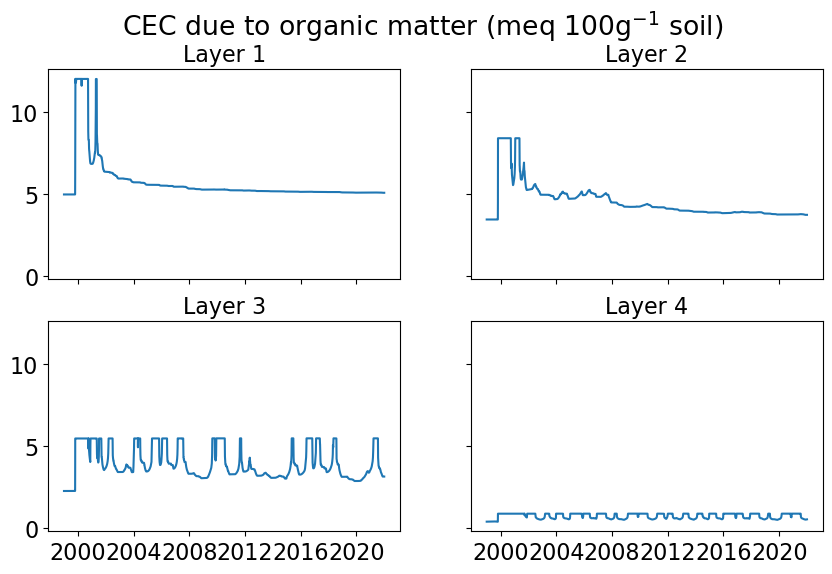

In [3]:
# Check potential of OM-pH response on CEC
# : can explain the observed raise in CEC at Hubbard Brook

om_by_layer = np.array([99.389565, 67.096622, 43.420067, 6.661048, 8.085962, 
                        9.899382, 4.011565, 1.256715]) # kg/m3

fig, axes = plt.subplots(2, 2, figsize = (10, 6), sharex = True, sharey = True)
for layer in range(4):
    # CEC (meq/100g organic matter) = -59 + 51 * pH
    # convert from OM basis to soil basis
    # meq/100g OM * (100g OM/m3 soil) / (100g soil/m3 soil)
    cec_om = pd.Series(
        (-59 + hr['soil_pH'][:,layer,0]*51)*(10*om_by_layer[layer]*0.58) / \
        (hr['bd_col'][:,layer,0]*10), 
        index = tvec
    )
    cec_om = cec_om.loc[cec_om.index.year >= 1999]

    ax = axes.flat[layer]
    ax.plot(cec_om.index, cec_om.values)
    ax.set_title(f'Layer {layer+1}')
fig.suptitle('CEC due to organic matter (meq 100g$^{-1}$ soil)')

In [ ]:
# C sequestration rate and amount dissolved Ca2+
compare = pd.DataFrame(
    {'ca_dissolve': np.sum(hr['primary_cation_flux_vr_1'][:, :8, 0] * \
                           elm_thickness.reshape(1, -1), axis = 1), 
     'r_sequestration': hr['r_sequestration'][:, 0] - hr_ctrl['r_sequestration'][:,0],
     'r_trmt': hr['r_sequestration'][:, 0],
     'r_ctrl': hr_ctrl['r_sequestration'][:,0]
    }, index = tvec
)
compare = compare.loc[compare.index.year >= 1999, :]

fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(compare.index, compare['ca_dissolve'] / 40 * 86400, color = 'k')
ax.set_ylabel('Ca$^{2+}$ dissolution flux (mol m$^{-2}$ day$^{-1}$)')
ax2 = ax.twinx()
ax2.spines['right'].set_color('magenta')
ax2.tick_params(axis='y', colors='magenta')
ax2.yaxis.label.set_color('magenta')
ax2.plot(compare.index, compare['r_sequestration'] / 12 * 365 * 86400, color = 'magenta')
ax2.set_ylabel('Sequestration (mol m$^{-2}$ year$^{-1}$)')


fig, ax = plt.subplots(figsize = (8, 6))
h1, = ax.plot(compare.index, compare['r_trmt'].cumsum() / 12 * 86400, color = 'y')
h2, = ax.plot(compare.index, compare['r_ctrl'].cumsum() / 12 * 86400, color = 'g')
h3, = ax.plot(compare.index, compare['r_sequestration'].cumsum() / 12 * 86400, color = 'b')
ax.legend([h1,h2,h3], ['Treatment','Control','Trt-Ctrl'])
ax.set_ylabel('Cumulative sequestration (mol m$^{-2}$)')

In [ ]:
#hr.close()
#hr_ctrl.close()